In [1]:
!pip install catboost
!pip install tensorflow

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# data management
import pandas as pd
import numpy as np

# preprocessing
import re

import sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import tensorflow as tf

from catboost import CatBoostClassifier, Pool, metrics, cv

2024-04-13 18:51:31.781881: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-13 18:51:32.640118: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /data/software/default/openblas/0.3.15/lib:/data/software/default/cuda/11.4/lib64
2024-04-13 18:51:32.640196: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /data/software/default/openblas/0.3.15/lib:/data

In [3]:
df = pd.read_csv("./clean_data_2.csv", usecols=[1,2])

In [4]:
df.dropna(axis=0, inplace=True) #drop rows that contain any null values
df.reset_index(drop=True)

def remove_mentions(text):
  return re.sub(r'<@>', r'', text)

# add a mentions count column, and a tweet length column
df['mentions_count'] = [tweet.split().count('<@>') for tweet in df.tweet_text] #number of mentions in tweet
df['tweet_text'] = df['tweet_text'].apply(remove_mentions)
df['tweet_len'] = [len(tweet.split()) for tweet in df.tweet_text] #count words in tweet
df = df[df['tweet_len'] >= 2]
df.head()

,tweet_text,cyberbullying_type,mentions_count,tweet_len
0,in other words your food was crapilicious,0,0,7
1,why is so white,0,0,4
2,a classy whore or more red velvet cupcakes,0,1,8
3,gio meh p thanks for the heads up but not too...,0,1,18
4,this is an isis account pretending to be a ku...,0,1,17


In [5]:
df[df.cyberbullying_type == 5]

,tweet_text,cyberbullying_type,mentions_count,tweet_len
23882,fyi it looks like i was caught by it i am not...,5,1,15
23883,i need to just switch to an organization based...,5,0,22
23884,rmaed my monoprice shoddy power bricks on thos...,5,0,22
23886,life continues i have got the code to interpr...,5,0,22
23887,did not mention your name i call out behavior...,5,1,11
...,...,...,...,...
31700,no that is,5,3,3
31701,why are you giving these idiots airtime,5,1,7
31702,i am right now watching enforcers defend chums...,5,0,10
31703,misandry is not a word ios can autocomplete,5,0,8


In [7]:
df = df.drop(df[df.cyberbullying_type == 5].index)

In [27]:
df.cyberbullying_type.value_counts()

cyberbullying_type
2    7768
1    7660
3    7511
4    7429
0    6546
Name: count, dtype: int64

In [8]:
X = df.drop('cyberbullying_type', axis=1)
Y = df['cyberbullying_type']

In [10]:
from sklearn.model_selection import train_test_split

#Split 1 - 80/20
x_Train_1, x_Test_1, y_Train_1, y_Test_1 = train_test_split(
    X,
    Y,
    test_size=.2,
    random_state=100,
    shuffle=True
)

#Split 2 - 70/30
x_Train_2, x_Test_2, y_Train_2, y_Test_2 = train_test_split(
    X,
    Y,
    test_size=.3,
    random_state=100,
    shuffle=True
)

#Split 3 - 60/40
x_Train_3, x_Test_3, y_Train_3, y_Test_3 = train_test_split(
    X,
    Y,
    test_size=.4,
    random_state=100,
    shuffle=True
)

In [11]:
#Try pooling

train_pool_1 = Pool(data=x_Train_1,
                  label=y_Train_1,
                  text_features=['tweet_text']
                  )
test_pool_1 = Pool(data=x_Test_1,
                 label=y_Test_1,
                 text_features=['tweet_text'])

train_pool_2 = Pool(data=x_Train_2,
                  label=y_Train_2,
                  text_features=['tweet_text']
                  )

test_pool_2 = Pool(data=x_Test_2,
                 label=y_Test_2,
                 text_features=['tweet_text'])

train_pool_3 = Pool(data=x_Train_3,
                  label=y_Train_3,
                  text_features=['tweet_text']
                  )
test_pool_3 = Pool(data=x_Test_3,
                 label=y_Test_3,
                 text_features=['tweet_text'])

TBB Warning: The number of workers is currently limited to 4. The request for 63 workers is ignored. Further requests for more workers will be silently ignored until the limit changes.



In [12]:
# params = {
#     'iterations': 100,
#     'learning_rate': 0.1,
#     'eval_metric': 'MultiClass'
# }

In [14]:
def fit_model(train_pool):
    model = CatBoostClassifier(
        iterations=100,
        learning_rate=0.1,
        eval_metric='MultiClass',
    )

    return model.fit(train_pool)

model1 = fit_model(train_pool_1)
model2 = fit_model(train_pool_2)
model3 = fit_model(train_pool_3)

0:	learn: 1.3256290	total: 336ms	remaining: 33.3s
1:	learn: 1.1506684	total: 678ms	remaining: 33.2s
2:	learn: 1.0201835	total: 1.03s	remaining: 33.2s
3:	learn: 0.9157042	total: 1.34s	remaining: 32.2s
4:	learn: 0.8308699	total: 1.67s	remaining: 31.7s
5:	learn: 0.7608031	total: 2.09s	remaining: 32.8s
6:	learn: 0.7045363	total: 2.5s	remaining: 33.2s
7:	learn: 0.6543088	total: 2.9s	remaining: 33.4s
8:	learn: 0.6151904	total: 3.29s	remaining: 33.3s
9:	learn: 0.5778157	total: 3.69s	remaining: 33.2s
10:	learn: 0.5463491	total: 4.1s	remaining: 33.2s
11:	learn: 0.5177749	total: 4.5s	remaining: 33s
12:	learn: 0.4917117	total: 4.92s	remaining: 32.9s
13:	learn: 0.4695397	total: 5.32s	remaining: 32.7s
14:	learn: 0.4484259	total: 5.74s	remaining: 32.5s
15:	learn: 0.4304174	total: 6.14s	remaining: 32.2s
16:	learn: 0.4141956	total: 6.57s	remaining: 32.1s
17:	learn: 0.4006426	total: 6.96s	remaining: 31.7s
18:	learn: 0.3880282	total: 7.29s	remaining: 31.1s
19:	learn: 0.3768268	total: 7.64s	remaining: 30

63:	learn: 0.2509725	total: 19.9s	remaining: 11.2s
64:	learn: 0.2496708	total: 20.2s	remaining: 10.9s
65:	learn: 0.2491168	total: 20.5s	remaining: 10.6s
66:	learn: 0.2487601	total: 20.8s	remaining: 10.2s
67:	learn: 0.2480724	total: 21.1s	remaining: 9.91s
68:	learn: 0.2476204	total: 21.4s	remaining: 9.59s
69:	learn: 0.2470069	total: 21.6s	remaining: 9.28s
70:	learn: 0.2467018	total: 21.9s	remaining: 8.95s
71:	learn: 0.2460586	total: 22.2s	remaining: 8.64s
72:	learn: 0.2452040	total: 22.5s	remaining: 8.33s
73:	learn: 0.2442692	total: 22.8s	remaining: 8.02s
74:	learn: 0.2438921	total: 23.1s	remaining: 7.71s
75:	learn: 0.2437774	total: 23.4s	remaining: 7.39s
76:	learn: 0.2434650	total: 23.7s	remaining: 7.08s
77:	learn: 0.2432596	total: 24s	remaining: 6.76s
78:	learn: 0.2425689	total: 24.3s	remaining: 6.45s
79:	learn: 0.2419801	total: 24.6s	remaining: 6.14s
80:	learn: 0.2417388	total: 24.9s	remaining: 5.84s
81:	learn: 0.2413456	total: 25.2s	remaining: 5.53s
82:	learn: 0.2405891	total: 25.5s

In [15]:
y_pred_1 = [pred[0] for pred in model1.predict(test_pool_1)]
y_pred_2 = [pred[0] for pred in model2.predict(test_pool_2)]
y_pred_3 = [pred[0] for pred in model3.predict(test_pool_3)]

In [16]:
test_pools = [test_pool_1, test_pool_2, test_pool_3]
models = [model1, model2, model3]

In [17]:
Model_1_Results = 'Model 1 Accuracy : {0:0.4f}\n'. format(accuracy_score(y_Test_1, y_pred_1)) + '\nModel 1 Classification Report:\n' + classification_report(y_Test_1, y_pred_1) + '\n\n'

Model_2_Results = 'Model 2 Accuracy : {0:0.4f}\n'. format(accuracy_score(y_Test_2, y_pred_2)) + '\nModel 2 Classification Report:\n' + classification_report(y_Test_2, y_pred_2) + '\n\n'

Model_3_Results = 'Model 3 Accuracy : {0:0.4f}\n'. format(accuracy_score(y_Test_3, y_pred_3)) + '\nModel 3 Classification Report:\n' + classification_report(y_Test_3, y_pred_3) + '\n\n'

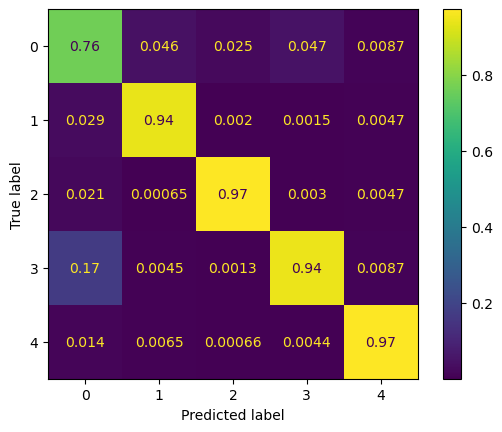

In [26]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

conf1 = confusion_matrix(y_Test_1, y_pred_1, normalize='pred')
ConfusionMatrixDisplay(conf1).plot()

In [18]:
# filename = "catboost_results_2.txt"

# with open(filename, 'w') as f:
#   f.write('Model 1 Params:\n' + str(model1.get_params())+ '\n\n')
#   f.write(Model_1_Results + '\n\n')
#   f.write('Model 2 Params:\n' + str(model2.get_params())+ '\n\n')
#   f.write(Model_2_Results + '\n\n')
#   f.write('Model 3 Params:\n' + str(model3.get_params())+ '\n\n')
#   f.write(Model_3_Results + '\n\n')
#   f.close()